## UNet for mean-flow 

we will design the network for mean-flow using Unet 

> the architecture does downsample the image and then upsample. the downsample and upsample can or cannot use attention blocks. If attention blocks are used - then they are conditioned on timestep, class embeddings or latents. 

> In standard unet, we just add class embedding and timestep embedding . class embedding just come from lookup table which is initialized as `nn.Parameter(class_labels, embedding_dim)`. this is a 1D layer.

> time usually ranges from 0-1000, we will generate a vector which is again 1D with some required dim.

In [49]:
import torch 
import math

import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline


## Time step embedding

- we usually select time from 0-999
- embedding dim: choose your choice of embedding dimesion. usually 128, 256 etc are choosen.
- we will discuss about sin-cos embedding used in original attention paper.

In [41]:
embedding_dim = 256
half_dim = embedding_dim // 2
half_dim

128

In [42]:
-math.log(10000)

-9.210340371976184

In [56]:
max_period = 10000
exponent = -math.log(max_period) * torch.arange(start=0, end=half_dim, dtype=torch.float32, device="cuda")
exponent.shape, exponent.max(), exponent.min()

(torch.Size([128]),
 tensor(-0., device='cuda:0'),
 tensor(-1169.7133, device='cuda:0'))

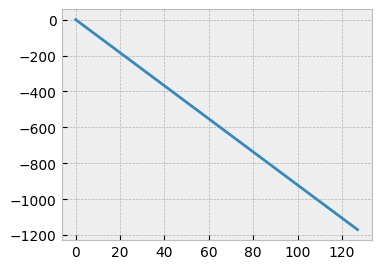

In [57]:
plt.figure(figsize=(4, 3))
plt.plot(exponent.cpu().numpy())
plt.show()

In [59]:
downscale_freq_shift = 0
exponent = exponent / (half_dim - downscale_freq_shift)
emb = torch.exp(exponent)
emb.shape, emb.max(), emb.min()

(torch.Size([128]),
 tensor(1., device='cuda:0'),
 tensor(0.0001, device='cuda:0'))

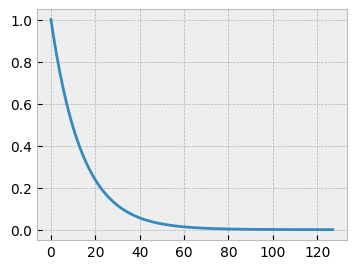

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(emb.cpu().numpy(),)
plt.show()

In [61]:
timesteps = torch.arange(0, 1000, 50).cuda()
print(timesteps.shape)
timesteps



torch.Size([20])


tensor([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
        700, 750, 800, 850, 900, 950], device='cuda:0')

In [62]:
emb = (timesteps[:, None].float() * emb[None, :])
emb.shape

torch.Size([20, 128])

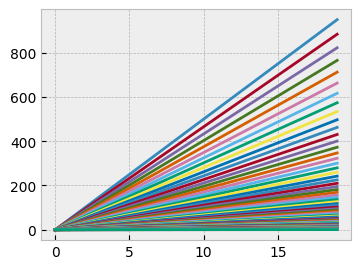

In [63]:
plt.figure(figsize=(4, 3))
plt.plot(emb.cpu().numpy())
plt.show()

In [64]:
emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
emb.shape

torch.Size([20, 256])

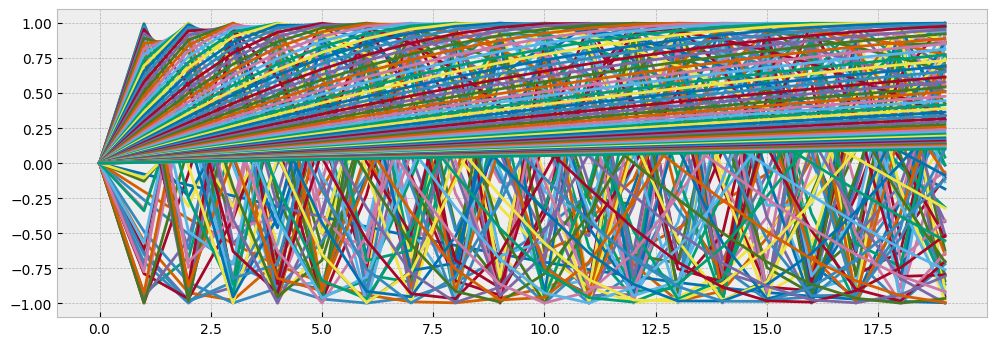

In [73]:
plt.figure(figsize=(12, 4))
plt.plot(emb[:, :128].cpu().numpy())
plt.show()

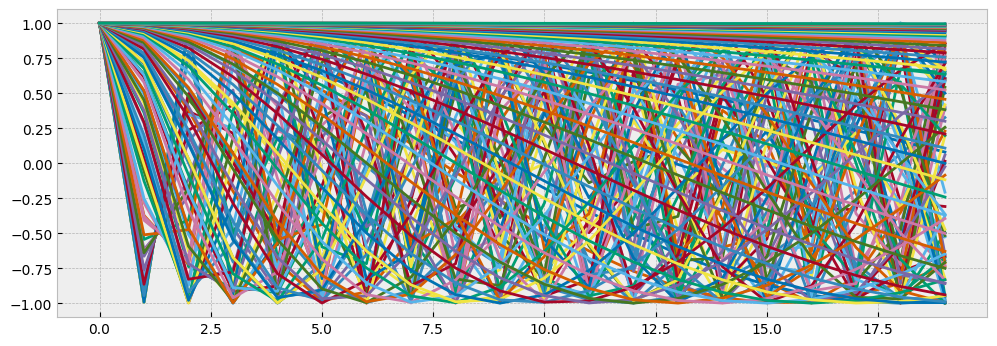

In [74]:
plt.figure(figsize=(12, 4))
plt.plot(emb[:, 128:].cpu().numpy())
plt.show()

In [75]:
# calculate the euclidean distance between two vectors
mag = torch.matmul(emb, emb.T)
mag.shape

torch.Size([20, 20])

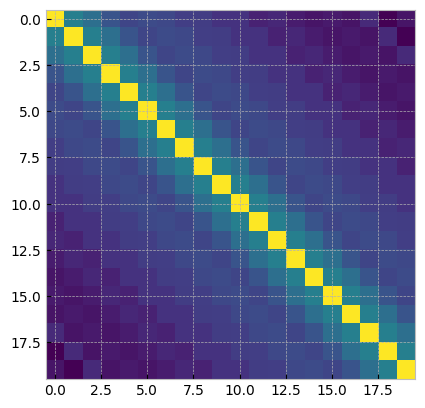

In [77]:
plt.imshow(mag.cpu().numpy())
plt.show()